<a href="https://colab.research.google.com/github/tunatuna123/MPI/blob/main/MPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MPI 다운로드

In [ ]:
! pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438481 sha256=2a18cd469ffe7716f273490c034db444857462c0e5dd57655b4c15ca612d8700
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


#Message Passing Interface(MPI)





---

### 1. 병렬컴퓨팅이란?

 복잡한 문제를 풀기 위해 연산을 나누어 서로 다른 processor에서 동시에 연산하는 연산의 방법 중 하나이다. 크고 복잡한 문제를 나누어 동시에 병렬적으로 연산하기 때문에 프로그램의 실행시간을 줄이는 것을 목적으로 사용한다. 

 병렬컴퓨팅의 종류 중 하나인 MPI(Message Passing Interface)를 이용한 병렬컴퓨팅의 경우에는 메시지를 주고 받는 형식으로 연산이 처리된다.

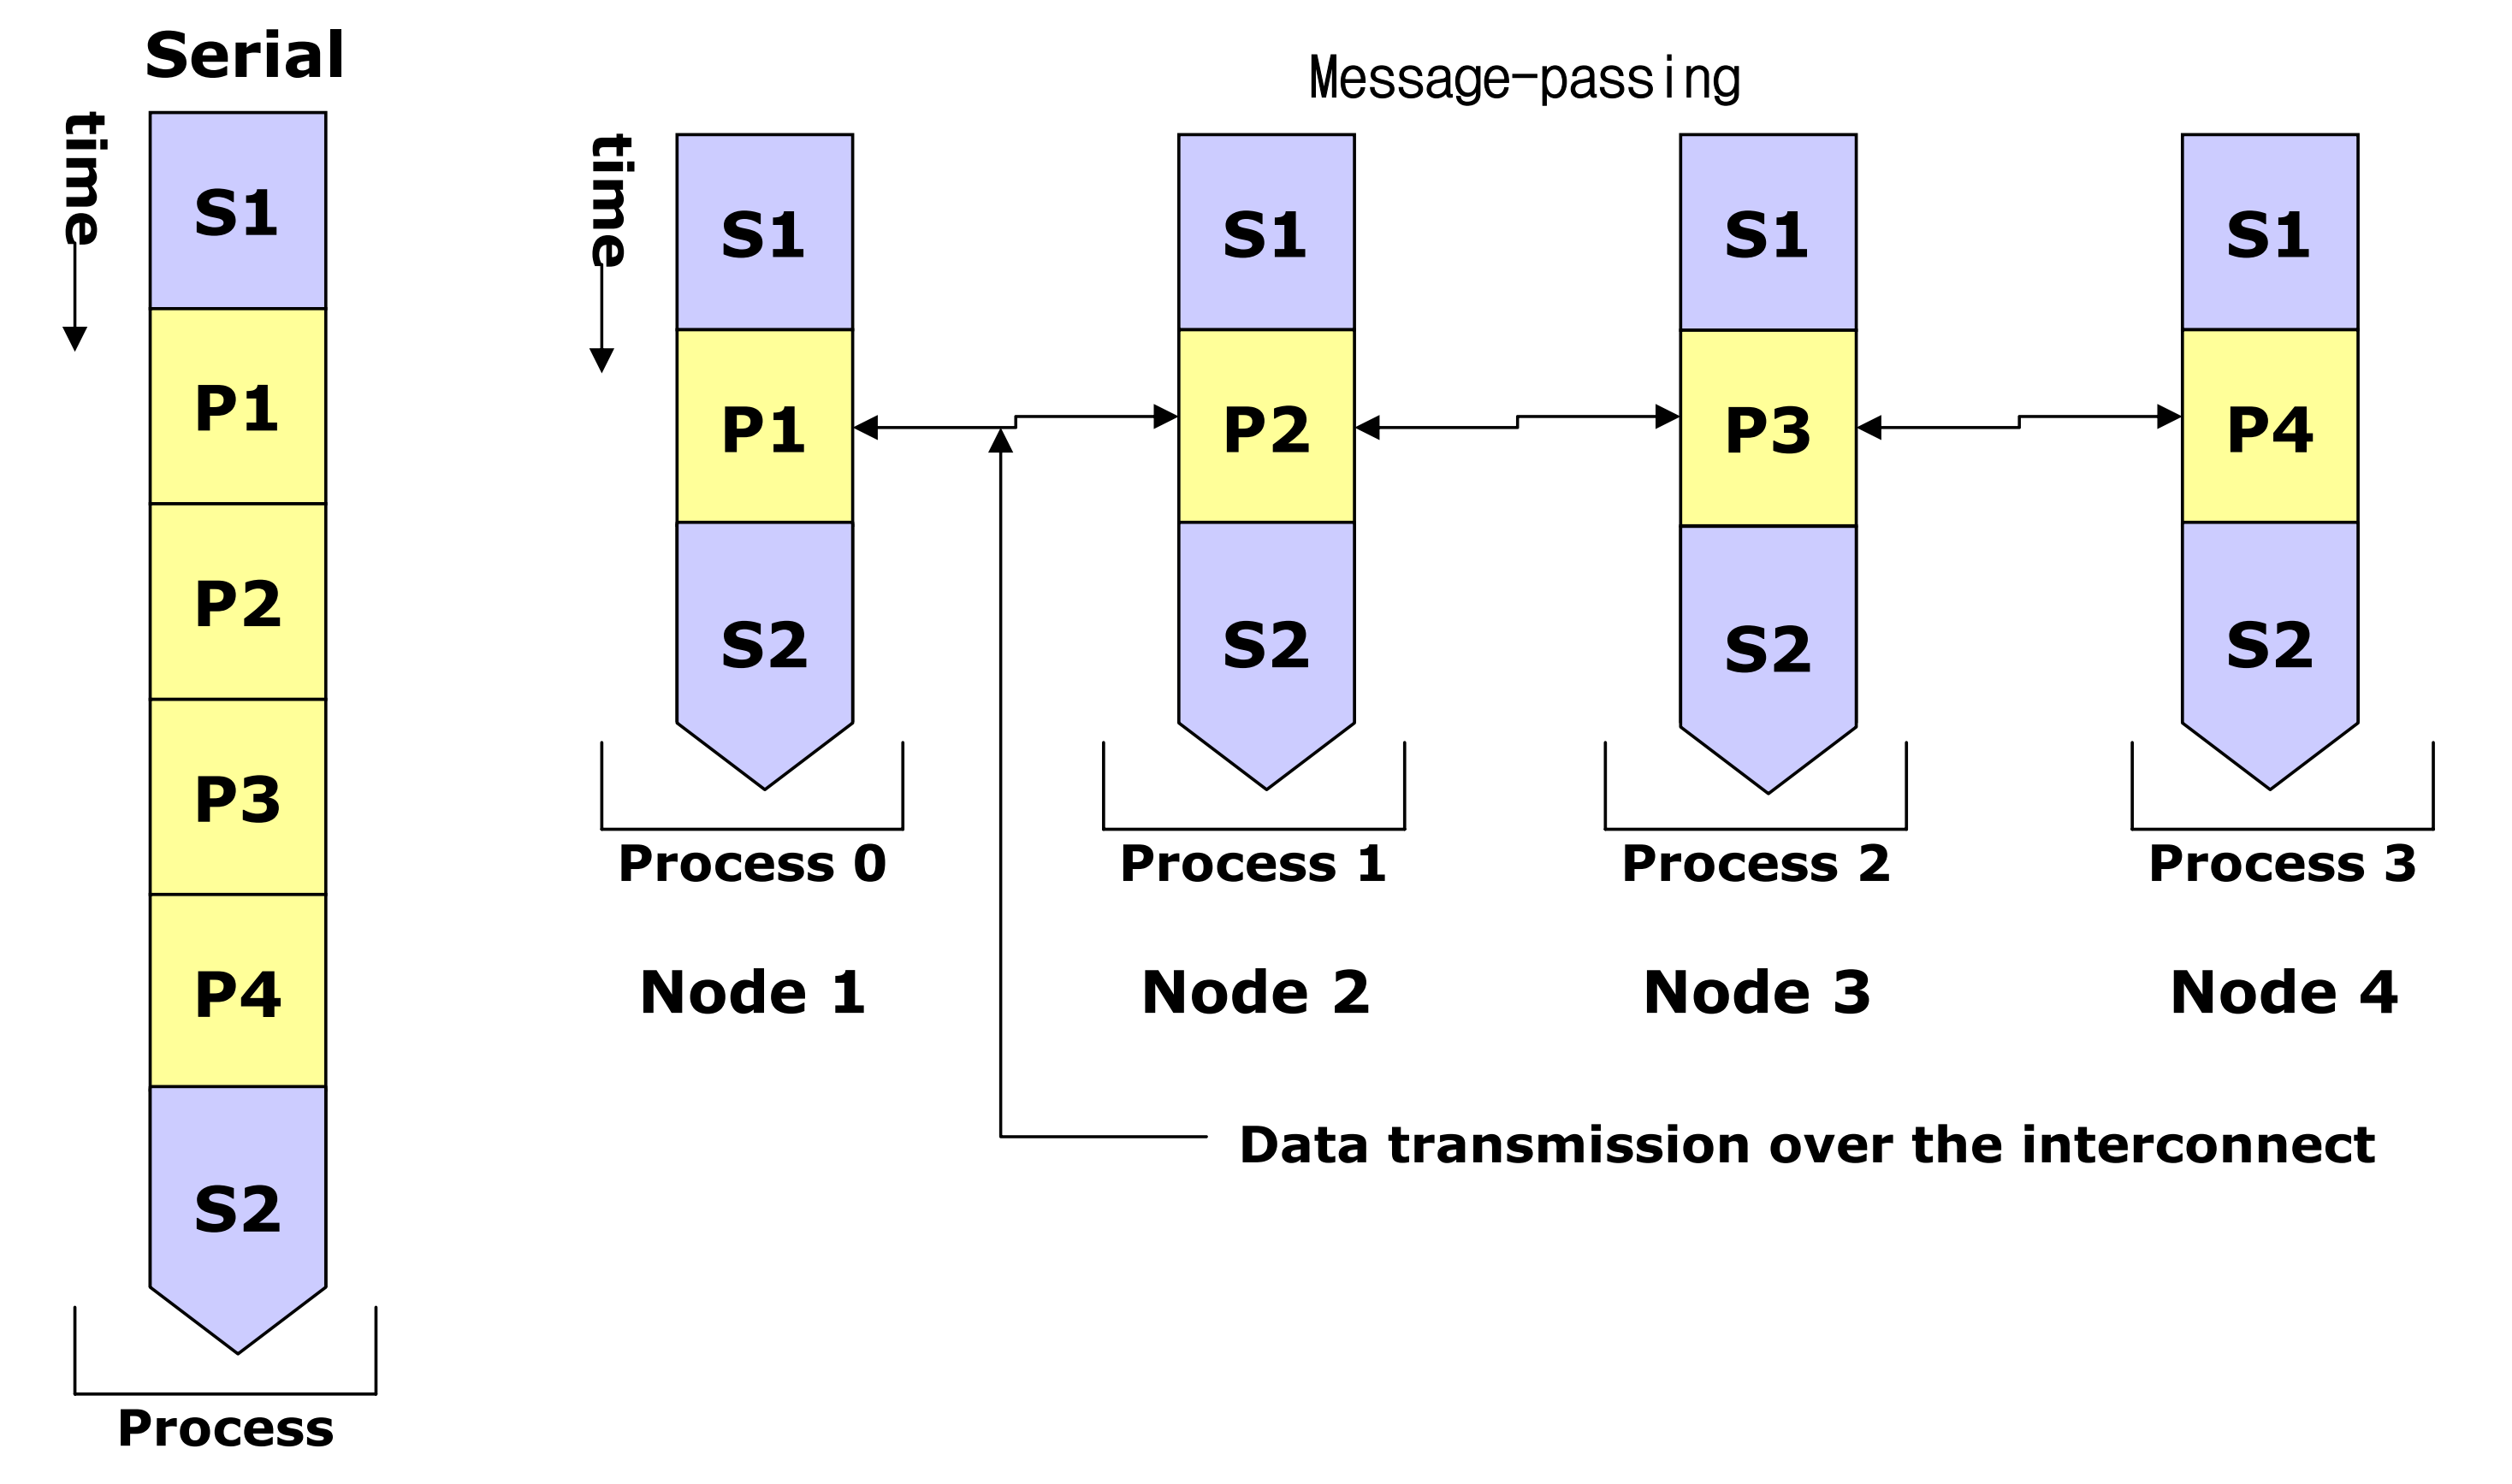

Python에서 병렬컴퓨팅은 주로 데이터 분석 시에 for 반복문이 중첩으로 여러 번 사용되어 시간복잡도가 너무 커지거나 데이터 자체의 사이즈가 너무 커서 핸들링 하기 어려운 경우 사용한다.

### 2. Mpi4py

 Mpi4py는 python에서 MPI를 사용할 수 있게 해주는 패키지이다.

**기본적인 문법**

- MPI.COMM_WORLD : communication world라는 뜻. MPI 연산을 하기 위해 processor들이 존재하는 공간이다.
- Processor : 연산들이 처리되는 각각의 공간
- Rank : Processor에게 부여되는 고유번호
- Size : MPI_COMM_WORLD에 존재하는 processor의 개수


 만약 Rank가 0이라면 Processor(0)에서, Rank가 1이라면 Processor(1)에서, …, Rank가 (Size-1)이라면 Processor(Size-1)에서 연산하겠다는 뜻이다. Rank는 (0)~(Size-1)까지의 수가 순서 없이(랜덤으로) 주어진다.

In [ ]:
%%writefile 00spmd.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    id = comm.Get_rank()            #number of the process running the code
    numProcesses = comm.Get_size()  #total number of processes running
    myHostName = MPI.Get_processor_name()  #machine name running the code

    print("Greetings from process {} of {} on {}".format(id, numProcesses, myHostName))
main()

Overwriting 00spmd.py


 위의 예시는 $n$개의 processor를 만들어 각 processor들이 자신의 rank와 processor의 이름을 print하는 스크립트이다.

In [ ]:
! mpirun --allow-run-as-root -np 8 python 00spmd.py

Greetings from process 3 of 8 on 051750fe32d1
Greetings from process 4 of 8 on 051750fe32d1
Greetings from process 1 of 8 on 051750fe32d1
Greetings from process 7 of 8 on 051750fe32d1
Greetings from process 6 of 8 on 051750fe32d1
Greetings from process 2 of 8 on 051750fe32d1
Greetings from process 0 of 8 on 051750fe32d1
Greetings from process 5 of 8 on 051750fe32d1


###실행 명령어 구성>
mpirun : mpi 실행 명령

--allow-run-as-root : root 계정에서도 MPI를 강제실행시킴

-np $n$ : $n$개의 processor를 이용함

python <파일명> : 실행할 파일의 이름

#1. Processor끼리 메시지 주고 받는 방법 1(point-to-point communication, 점대점 통신)

Processor가 1대 1로 메시지를 주고 받는 것을 점대점 통신이라고 한다.
점대점 통신은 MPI.COMM_WORLD에 있는 send와 recv함수를 통해 구현할 수 있다.

send는 메시지를 보내는 함수(send), recv는 메시지를 받는 함수(receive)이다.

- send(data, dest, tag)
    - data	:  메시지로 보낼 변수 이름
    - dest	:  메시지가 도착할 Processor의 rank
    - tag	:  메시지를 구별하는 수
- recv(source, tag)
    - source :  메시지를 보냈던 Processor의 rank
    - tag	:  메시지를 구별하는 수

기본적으로 메시지를 주고 받는 형태는 다음과 같다.

###예시 1번
Processor(0)에서 Processor(1)로 10을 전송

In [ ]:
%%writefile send_and_recv.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    if rank == 0:
        k = 10
        comm.send(k, dest=1)
    elif rank == 1:
        r = comm.recv(source=0)
        print(r, rank)

main()

Overwriting sendandrecv.py


In [ ]:
! mpirun --allow-run-as-root -np 2 python send_and_recv.py

10 1


###예시 2번
1~10까지의 합을 구하는 병렬 프로그램

In [ ]:
%%writefile sum_to_ten.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    if rank == 0:
        sum = 0
        for i in range(1,6):
            sum += i
        comm.send(sum, dest=2)
    elif rank == 1:
        sum = 0
        for i in range(6,11):
            sum += i
        comm.send(sum, dest=2)
    elif rank == 2:
        a = comm.recv(source=0)
        b = comm.recv(source=1)
        print(a+b)

main()

Overwriting sum_to_ten.py


In [ ]:
! mpirun --allow-run-as-root -np 3 python sum_to_ten.py

55


###예시 3번
tag는 어디에 쓰는거지?

  위 코드를 보면 tag를 사용하지 않았다. 하지만, 상황에 따라서 tag가 반드시 필요하기도 하다.

같은 Processor A에서 서로 다른 두 개 이상의 메시지를 같은 Processor에 보낸다고 가정하자.

메시지를 받는 Processor B의 입장에서 서로 다른 두개 이상의 메시지를 어떻게 구별해야 할까?

  이를 해결하기 위해 존재하는 것이 바로 tag이다.

1에서 5 까지 합을 Processor(0)에서 Processor(1)로, 6에서 10 까지 합도 Processor(0)에서 Processor(1)로 보낸다고 할때, 두 메시지를 구별할 수 있게 위해서
1에서 5 까지의 합을 보내는 메시지에는 0이라는 tag를
6에서 10 까지의 합을 보내는 메시지에는 1이라는 tag를 붙이는 것이다.

메시지를 받을 때에는 Processor(0)에서 보낸 메시지이기 때문에 source=0으로 설정해 주고,
tag는
1~5  까지의 합을 받고 싶다면 tag를 0으로,
1~10까지의 합을 받고 싶다면 tag를 1로 설정해 주면 된다.


In [ ]:
%%writefile sum_to_ten_with_tag.py
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    if rank==0 :
        sum = 0
        for i in range(1, 6):
            sum += i
        comm.send(sum, dest=1, tag=0) # Processor(1)에 합을 태그(0)을 달아서 보냄
        sum = 0
        for i in range(6, 11):
            sum += i
        comm.send(sum, dest=1, tag=1) # Processor(1)에 합을 태그(1)을 달아서 보냄
    elif rank==1 :
        a = comm.recv(source=0, tag=0) # 	tag=0인 Processor(0)에서 온 메시지 받음
        b = comm.recv(source=0, tag=1) # tag=1인 Processor(0)에서 온 메시지 받음
        print(a+b)

main()


Overwriting sum_to_ten_with_tag.py


In [ ]:
! mpirun --allow-run-as-root -np 2 python sum_to_ten_with_tag.py

55


#2. Processor끼리 메시지 주고 받는 방법 2(Collective communication, 집합 통신)

  앞서 보았던 점대점 통신과 다르게, 집합 통신은 하나의 Processor와 2개 이상의 Processor가 메시지를 주고 받는다.

  집합 통신을 구현하기 위해서 MPI.COMM_WORLD에 있는 gather, scatter 함수를 사용하며,
scatter는 각 Processor에 작업을 뿌려주고, gather는 각 Processor에 뿌려져있던 데이터를 모으는 역할을 수행한다.

- scatter(data, root)
    - data	:  각 Processor에 나누어 뿌려줄 변수 이름
    - root	:  앞서서 보았던 tag와 같은 역할
- gather(data, root)
    - data	:  각 Processor에 나누어져 있던  변수 이름
    - root	:  앞서서 보았던 tag와 같은 역할

###예시 1번
각각 processor의의 rank를를 gather하는는 프로그램

In [ ]:
%%writefile gather1.py
import numpy as np
from mpi4py import MPI

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size ()
    recvbuf = comm.gather(rank)
    if rank == 0:
        print("Gathered array: {}".format(recvbuf))

main()

Writing gather1.py


In [ ]:
! mpirun --allow-run-as-root -np 4 python gather1.py

Gathered array: [0, 1, 2, 3]


In [ ]:
! mpirun --allow-run-as-root -np 9 python gather1.py

Gathered array: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
%%writefile gather2.py
from mpi4py import MPI
import numpy as np
import random
def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank ()
    size = comm.Get_size ()

    local = random.randint(2, 5)
    print("rank: {}, local: {}".format(rank, local))

    sum = comm.reduce(local, MPI.SUM, root=0)
    if (rank==0):
        print ("sum: ", sum)

main()

Overwriting gather2.py


In [ ]:
! mpirun --allow-run-as-root -np 4 python gather2.py

rank: 1, local: 2
rank: 2, local: 5
rank: 0, local: 4
rank: 3, local: 4
sum:  15
